# Ddistributed Learning Radiomics (DLR) - centralized analysis notebook 

## Replicate Hugo Aerts' Nature Communication through a centralized learning approach between MAASTRO (Lung-1) and Radbound (Lung-2)

## Author: Zhenwei Shi, PhD student, MAASTRO Clinic

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns
# lifelines
from lifelines import CoxPHFitter,KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test 
import warnings
warnings.filterwarnings('ignore')

def confidence_interval(stats,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

## Data preparation
### Loading Lung-1 and Lung-2 clinical data and radiomic features, then merging them to one dataframe.

In [4]:
# predictors and outcome used in the original article
hugo_predictors = [
    "original_firstorder_Energy",
    "original_shape_Compactness",
    "original_glrlm_GrayLevelNonUniformity",
    "wavelet-HLH_glrlm_GrayLevelNonUniformity"]

hugo_outcome = ["deadstatus.event","Survival.time"]

# ---------------- load lung1 data ---------------
df1_radiomics= pd.read_csv('./data/DLR_LUNG1_Radiomics.csv')
df1_clinical = pd.read_csv('./data/DLR_LUNG1_ClinicalUpdated.csv')
df1_merge = df1_radiomics.merge(df1_clinical,on = "patient_id")
# Compactness = Sphericity ** 3
df1_merge['original_shape_Sphericity'] = df1_merge['original_shape_Sphericity'] **3
df1_merge = df1_merge.rename(index=str,columns={'original_shape_Sphericity':'original_shape_Compactness'})
df1_merge = df1_merge.rename(index=str,columns={'Updated.Survival.time':'Survival.time'})
df1_merge = df1_merge.rename(index=str,columns={'Updated.deadstatus.event':'deadstatus.event'})
dflung1 = df1_merge[hugo_predictors + hugo_outcome]
# ---------------- load lung2 data ---------------
dflung2 = pd.read_csv('./data/DLR_LUNG2_Radiomics_ClinicalUpdated.csv')
dflung2['original_shape_Sphericity'] = dflung2['original_shape_Sphericity'] **3
dflung2 = dflung2.rename(index=str,columns={'original_shape_Sphericity':'original_shape_Compactness'})
dflung2 = dflung2[hugo_predictors + hugo_outcome]

## Data pre-processing

In [5]:
# pre-processing
# data transformation using log10
dflung1[hugo_predictors] = np.log10(dflung1[hugo_predictors])
dflung2[hugo_predictors] = np.log10(dflung2[hugo_predictors])
# all features are normalized by using z-score normalization
dflung1_f = dflung1[hugo_predictors]
dflung2_f = dflung2[hugo_predictors]
dflung2[hugo_predictors] = (dflung2[hugo_predictors] - dflung1_f.mean(axis=0)) / (dflung1_f.std(axis=0, ddof=0))
# dflung2[hugo_predictors] = (dflung2[hugo_predictors] - dflung2_f.mean(axis=0)) / (dflung2_f.std(axis=0, ddof=0))
dflung1[hugo_predictors] = (dflung1[hugo_predictors] - dflung1_f.mean(axis=0)) / (dflung1_f.std(axis=0, ddof=0))

### Box plot to check the distribution of features in lung1 and lung2 cohorts

In [6]:
# dflung1_box = dflung1[hugo_predictors]
# dflung2_box = dflung2[hugo_predictors]
# data1 = pd.DataFrame(columns= ['Feature','Value','Cohort'])
# data2 = pd.DataFrame(columns= ['Feature','Value','Cohort'])

# # ------- create a data structure for sns.boxplot ------------
# feature1 = pd.Series()
# value1 = pd.Series()
# feature2 = pd.Series()
# value2 = pd.Series()
# for i in range(dflung1_box.shape[0]):
#     feature1 = feature1.append(pd.Series(hugo_predictors))
#     value1 = value1.append(dflung1_box.iloc[i,:])
# for i in range(dflung2_box.shape[0]):
#     feature2 = feature2.append(pd.Series(hugo_predictors))
#     value2 = value2.append(dflung2_box.iloc[i,:])
# data1['Feature'] = feature1
# data1['Value'] = value1.values[:]
# data1['Cohort'] = 'Training (Lung1)'
# data2['Feature'] = feature2
# data2['Value'] = value2.values[:]
# data2['Cohort'] = 'Testing (Lung2)'
# #--------------------
# data = pd.concat([data1,data2])
# plt.figure(figsize=(20,10))
# ax = sns.boxplot(x = 'Feature',y = 'Value',hue = 'Cohort', color='grey',data = data)
# plt.xlabel("Feature",fontsize = 'x-large')
# plt.ylim(-5,20)
# plt.ylabel("Feature Value (z-score and Log10 transformation)",fontsize = 'x-large')
# # plt.savefig('./DLR_result/Log_BoxPlot.pdf')
# plt.show()

## Multivariate Cox proportional hazards regression model 
### Developing on Lung-1 -- Validation on Lung-2

In [7]:
alpha = 0.95 # parameter for 95% confidence interval
cox1 = CoxPHFitter()
cox1.fit(dflung1.dropna(axis=0), duration_col='Survival.time', event_col='deadstatus.event')
cox1.print_summary() # access the results using cph.summary

n=421, number of events=374

                                            coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
original_firstorder_Energy                0.0517     1.0531    0.0996  0.5195 0.6034     -0.1435      0.2469   
original_shape_Compactness               -0.0151     0.9850    0.0579 -0.2603 0.7946     -0.1287      0.0985   
original_glrlm_GrayLevelNonUniformity     0.0764     1.0794    0.4296  0.1778 0.8588     -0.7655      0.9183   
wavelet-HLH_glrlm_GrayLevelNonUniformity  0.0788     1.0820    0.4697  0.1678 0.8668     -0.8418      0.9994   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.583
Likelihood ratio test = 13.437 on 4 df, p=0.00932


### Statistic Analysis

To calculate significance between two models we used a bootstrap approach, for 100 times we calculated the CI of both models from 100 randomly selected samples. The Wilcoxon test was used to assess significance.

A similar approach was used to assess if the signature had significant power,compared with random (CI = 0.5). We used a bootstrap approach, for 100 times we calculated the CI of the radiomics signature based on 100 randomly selectedsamples with correct outcome data, as well as on 100 randomly chosen samples with random outcome data. The Wilcoxon test was used to assess significance, between the two distributions.

Materials: 
c-index in lifelines: https://stats.stackexchange.com/questions/352183/use-median-survival-time-to-calculate-cph-c-statistic/352435?newreg=ce02824b19bb44ef8a084ac1ad25a298
Wilcoxon test: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html

In [12]:
# ----------------------------Entire Concordance Index -----------
# dflung1_4f = dflung1.drop(['Survival.time','deadstatus.event'],axis=1)
# estimated_time1 = cox1.predict_expectation(dflung1_4f) # estimated survival time
# C_index1 = concordance_index(dflung1['Survival.time'],estimated_time1,dflung1['deadstatus.event'])
# print('Concordance Index of Lung1: %f' %C_index1)

# dflung2_4f = dflung2.drop(['Survival.time','deadstatus.event'],axis=1)
# estimated_time2 = cox1.predict_expectation(dflung2_4f) # estimated survival time
# C_index2 = concordance_index(dflung2['Survival.time'],estimated_time2,dflung2['deadstatus.event'])
# print('Concordance Index of Lung2: %f' %C_index2)
# --------------------------Wilcoxon Test with 100 times boostrapping (100 samples each time) 
n_bs = 100 # bootstrap 100 times 
C_index1_bs = []
for i in range(n_bs):
    dflung1_bs = dflung1.sample(n_bs,replace=True)
    dflung1_4f = dflung1_bs.drop(['Survival.time','deadstatus.event'],axis=1)
    estimated_time = cox1.predict_expectation(dflung1_4f) # estimated survival time
    CI = concordance_index(dflung1_bs['Survival.time'],estimated_time,dflung1_bs['deadstatus.event'])
    C_index1_bs.append(CI)

# scipy.stats Wilcoxon test,  two-sided p-value for the test
T1, p_wilcoxon1 = stats.wilcoxon(C_index1_bs,np.ones(n_bs)*0.5)
print('P value of wilcoxon test of Lung1:')
print(p_wilcoxon1)
print('Mean CI of 100 times boostrapping of Lung1:' %np.mean(C_index1_bs))
confidence_interval(C_index1_bs,alpha)
C_index2_bs = []
for i in range(n_bs):
    dflung2_bs = dflung2.sample(n_bs,replace=True)
    dflung2_4f = dflung2_bs.drop(['Survival.time','deadstatus.event'],axis=1)
    estimated_time = cox1.predict_expectation(dflung2_4f) # estimated survival time
    CI = concordance_index(dflung2_bs['Survival.time'],estimated_time,dflung2_bs['deadstatus.event'])
    C_index2_bs.append(CI)

# scipy.stats Wilcoxon test,  two-sided p-value for the test
T2, p_wilcoxon2 = stats.wilcoxon(C_index2_bs,np.ones(n_bs)*0.5)
print('P value of wilcoxon test of Lung2:')
print(p_wilcoxon2)
print('Mean CI of 100 times boostrapping of Lung2: %f' %np.mean(C_index2_bs))
confidence_interval(C_index2_bs,alpha)

P value of wilconxon test of Lung1:
4.0161556854627e-18
Mean CI of 100 times boostrapping of Lung1:
95.0 confidence interval 52.0% and 63.8%
P value of wilconxon test of Lung2:
6.12472726248735e-18
Mean CI of 100 times boostrapping of Lung2: 0.586229
95.0 confidence interval 51.3% and 64.7%


### Prognostic index 

In [9]:
# prognostic index of 
pi_lung1 = np.sum(cox1.summary.coef*dflung1[hugo_predictors],axis=1)
pi_lung2 = np.sum(cox1.summary.coef*dflung2[hugo_predictors],axis=1)

# meadian prognostic index of Lung 1 as the separator
sep_median_lung1 = np.median(pi_lung1)
dflung1_high = dflung1[pi_lung1 <= sep_median_lung1]
dflung1_low =dflung1[pi_lung1 > sep_median_lung1]

sep_median_lung2 = np.median(pi_lung2)
dflung2_high = dflung2[pi_lung2 <= sep_median_lung1]
dflung2_low =dflung2[pi_lung2 > sep_median_lung1]

In [24]:
# lung1 = pd.concat([dflung1['Survival.time'],dflung1['deadstatus.event'],pd.DataFrame(data = pi_lung1)],axis=1)
# lung2 = pd.concat([dflung2['Survival.time'],dflung2['deadstatus.event'],pd.DataFrame(data = pi_lung2)],axis=1)
# lung1.to_csv('MATLAB_Lung1.csv')
# lung2.to_csv('MATLAB_Lung2.csv')
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
37.0,0.993939
43.0,0.987879
50.0,0.981818
53.0,0.975758
63.0,0.969697
77.0,0.963636
83.0,0.957576
88.0,0.951515


### Kaplan-Meier Analysis

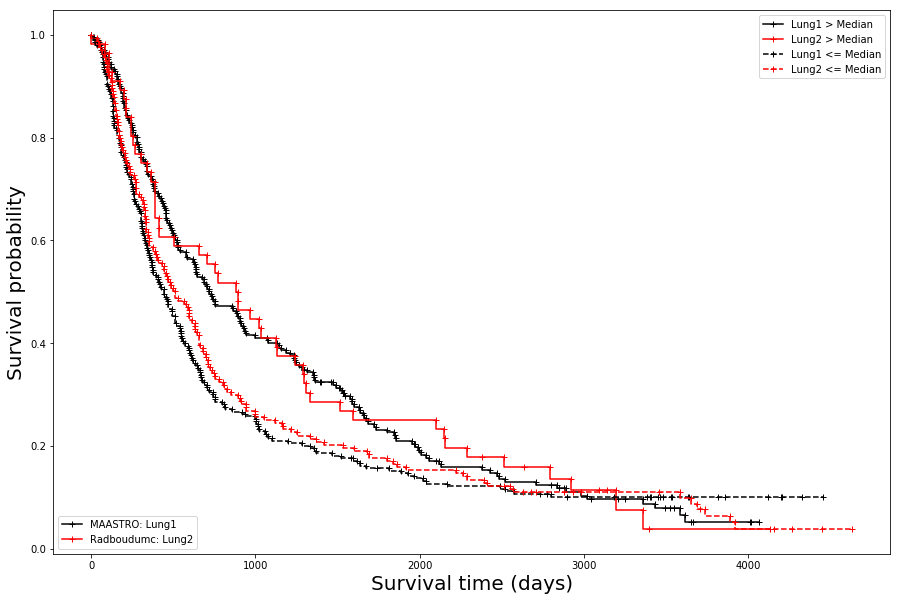

In [10]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(15,10))
# plt.xlim(0,1500)
plt.xlabel("Survival time (days)", {"fontsize": 20})
plt.ylabel("Survival probability", {"fontsize": 20})
# plt.title("Kaplan_Meier radiomics signature", {"fontsize": 20, "fontweight": "bold"})

kmf.fit(dflung1_high["Survival.time"], event_observed=dflung1_high["deadstatus.event"])
plt.plot(kmf.survival_function_, "k+-",drawstyle='steps')

kmf.fit(dflung2_high["Survival.time"], event_observed=dflung2_high["deadstatus.event"])
plt.plot(kmf.survival_function_, "r+-",drawstyle='steps')

kmf.fit(dflung1_low["Survival.time"], event_observed=dflung1_low["deadstatus.event"])
plt.plot(kmf.survival_function_, "k+--",drawstyle='steps')

kmf.fit(dflung2_low["Survival.time"], event_observed=dflung2_low["deadstatus.event"])
plt.plot(kmf.survival_function_, "r+--",drawstyle='steps')

first_legend = plt.legend(["Lung1 > Median", "Lung2 > Median", "Lung1 <= Median", "Lung2 <= Median"])
ax = plt.gca().add_artist(first_legend)
plt.legend(["MAASTRO: Lung1", "Radboudumc: Lung2"], loc=3)
# plt.savefig('./DLR_result/DLR_KM_log_4features.pdf')
# plt.savefig('./DLR_result/DLR_KMfull_log_4features.pdf')
plt.show()

### Log-rank test returns Chi-square statistic score and p-value

In [10]:
results_1 = logrank_test(dflung1_low["Survival.time"], dflung1_high["Survival.time"], event_observed_A=dflung1_low["deadstatus.event"], event_observed_B=dflung1_high["deadstatus.event"])
results_2 = logrank_test(dflung2_low["Survival.time"], dflung2_high["Survival.time"], event_observed_A=dflung2_low["deadstatus.event"], event_observed_B=dflung2_high["deadstatus.event"])
results_1.print_summary()
results_2.print_summary()


df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p    
        6.8237 0.0090  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        2.3547 0.1249
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
